# Creating hot gas density profiles and measuring gas mass

Though this work is generally concerned with detected absorption of background Quasar emission by warm gas in the intra-cluster/group medium, it also seemed appropriate to measure the quantity of hot, X-ray emitting, gas present in the intra-cluster medium. This involves creating a density profile, and there is a method (using surface brightness profiles) which can be used with low signal-to-noise extended sources. We then calculate the total gas mass by spherically integrating that profile within overdensity radii for all of our systems.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree
from matplotlib import pyplot as plt

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 35
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/radial_prof_analyses')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model
from xga.products import BaseAggregateProfile1D
    
%matplotlib inline

## Setting up directories

Need to make sure that some of the directories that we will be storing output files and figures in actually exist:

In [44]:
if not os.path.exists('../../outputs/results/'):
    os.makedirs('../../outputs/results/')
    
if not os.path.exists('../../outputs/figures/gm_prop_comparisons/'):
    os.makedirs('../../outputs/figures/gm_prop_comparisons/')

## Reading the XGA sample files

We read in the files generated by our various runs of the XGA-LTR in another notebook in this repository. They contain the radii we measured, as well as all the other information that we need to declare an XGA ClusterSample:

In [2]:
r500_samp = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
r500_metfree_samp = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
r500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r500_froztemp_pipeline_results.csv')

r2500_samp = pd.read_csv('../../outputs/results/ltr_r2500_pipeline_results.csv')
r2500_metfree_samp = pd.read_csv('../../outputs/results/ltr_r2500_metfree_pipeline_results.csv')
r2500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv')

We show one of the dataframes to illustrate the contents:

In [3]:
r500_samp

,name,ra,dec,redshift,r500,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124,243.629055,26.730240,0.186,894.328175,4.09508,0.336509,0.428803,7.160965e+43,1.654052e+42,1.409422e+42,2.126731e+44,1.185634e+43,1.248581e+43,4.089550,0.541060,0.776698,4.365940e+43,1.182220e+42,1.034055e+42,1.295826e+44,1.153971e+43,1.158880e+43
1,44739,229.793620,28.331750,0.118,420.327709,1.01750,0.070825,0.086338,2.087752e+42,2.763224e+41,3.007630e+41,3.642512e+42,4.272690e+41,4.755757e+41,0.997597,0.086556,0.089026,1.703969e+42,2.508437e+41,1.974190e+41,2.946334e+42,2.406044e+41,5.992094e+41
2,19670A,150.256710,50.793942,0.134,471.746417,1.19978,0.119322,0.137150,1.473682e+42,2.794262e+41,2.535198e+41,2.769928e+42,4.937938e+41,7.943540e+41,1.278810,0.143419,0.158449,1.122548e+42,3.063895e+41,2.630961e+41,2.168193e+42,2.788445e+41,8.557280e+41
3,19670B,150.214920,50.805014,0.134,535.987637,1.57037,0.163560,0.225675,3.781171e+42,4.659777e+41,4.080644e+41,7.860725e+42,8.398733e+41,1.212557e+42,1.540700,0.177902,0.232237,3.274214e+42,3.825586e+41,2.633952e+41,6.766424e+42,7.349113e+41,1.161753e+42
4,12833,129.496800,44.248700,0.145,491.088940,1.37449,0.091825,0.103582,3.462101e+42,3.938930e+41,4.176430e+41,6.878208e+42,6.712414e+41,9.162024e+41,1.412940,0.131396,0.193668,2.240856e+42,2.757205e+41,3.609433e+41,4.495442e+42,8.299008e+41,7.554535e+41
5,44858,230.112000,28.887750,0.127,621.787069,2.07963,0.127336,0.173356,2.181280e+43,9.676633e+41,9.866408e+41,4.957341e+43,2.561646e+42,3.430648e+42,1.974800,0.137603,0.181453,1.546781e+43,9.979022e+41,6.827373e+41,3.457737e+43,2.669997e+42,2.986686e+42
6,PHL1811,328.769920,-9.588805,0.077,567.682822,1.66376,0.063290,0.063418,7.779805e+42,4.102416e+41,4.214600e+41,1.748087e+43,1.062815e+42,1.015352e+42,1.667990,0.090055,0.104340,5.006875e+42,3.197985e+41,2.995331e+41,1.125824e+43,9.642434e+41,1.137265e+42
7,50433,157.758000,30.862000,0.136,476.228525,1.26351,0.083351,0.094711,2.471845e+42,5.537633e+41,4.281101e+41,4.753694e+42,7.547387e+41,9.199127e+41,1.282590,0.111653,0.135354,1.759042e+42,4.224844e+41,3.402023e+41,3.404955e+42,5.223562e+41,1.094591e+42


## Setting up an XGA ClusterSample

We set up an XGA ClusterSample object for our systems - this will allow us to easily interact with all the XMM data for these objects, and perform measurements of their hot-gas density profiles. We make sure to set `use_peak=False`, so that the user defined coordinate (UDC) is used as the central position, as some of these systems are low enough signal to noise that they may produce unreliable peak coordinates:

In [4]:
srcs = ClusterSample(r500_samp['ra'].values, r500_samp['dec'].values, r500_samp['redshift'].values, 
                     r500_samp['name'].values, r500=Quantity(r500_samp['r500'].values, 'kpc'), 
                     use_peak=False, load_fits=True)
srcs.info()
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


-----------------------------------------------------
Number of Sources - 8
Redshift Information - True
Sources with ≥1 detection - 6 [75%]
-----------------------------------------------------




/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'44739': ['There are 1 alternative matches for observation 0900700201, associated with source 44739'],
 '19670A': ['There are 1 alternative matches for observation 0861080101, associated with source 19670A'],
 '19670B': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670B. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 'PHL1811': ["PHL1811 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 '50433': ['There are 1 alternative matches for observation 0102040301, associated with source 50433']}

## Generating hot gas density profiles

We generate surface brightness profiles, from ratemaps that have been corrected for the spatially varying PSF, and fit a simple $\beta$ model to them. This is inverse Abel transformed to recover a 3D emissivity profile, which in turn is used to calculate a 3D hot-baryon density profile with assumptions made about the emission model for the gas.

We have decided to generate the profiles to an outer radius of <font color="red">$1.1R_{500}$</font>, where the $R_{500}$ in question is that measured from the 'standard' XGA-LTR run:

In [96]:
rl_psf(srcs, bins=10)
d_profs = inv_abel_fitted_model(srcs, 'beta', outer_radius=srcs.r500, psf_bins=10)

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 8/8 [02:16<00:00, 17.07s/it]


Viewing the surface brightness profiles:

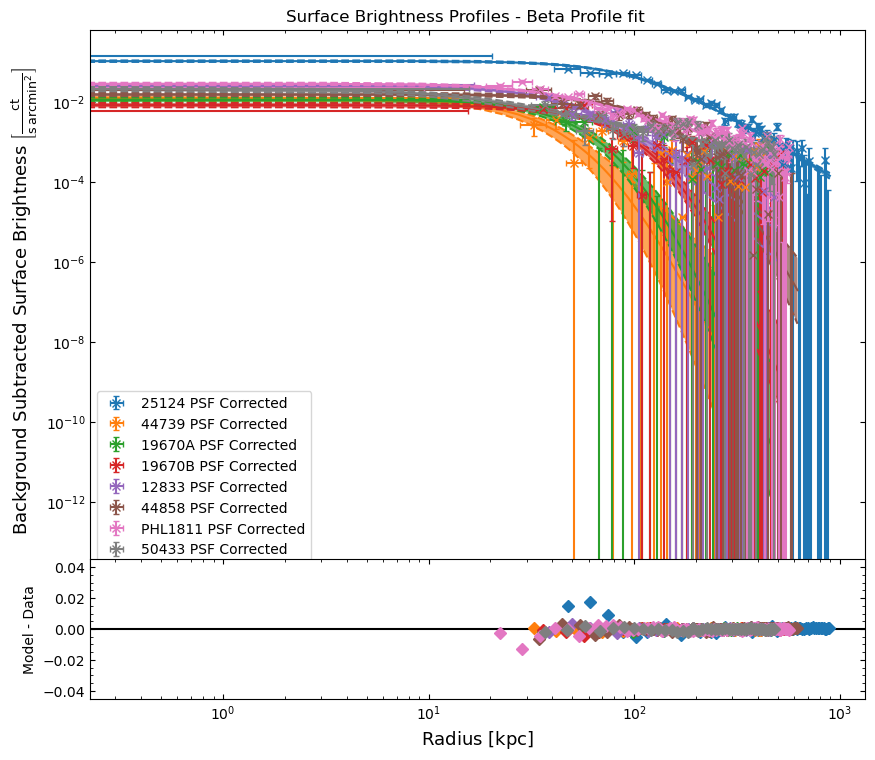

In [88]:
sb_profs = [dp.generation_profile for dp in d_profs]
BaseAggregateProfile1D(sb_profs).view(model='beta')

We also view the generated density profiles on one figure, and then save it to disk:

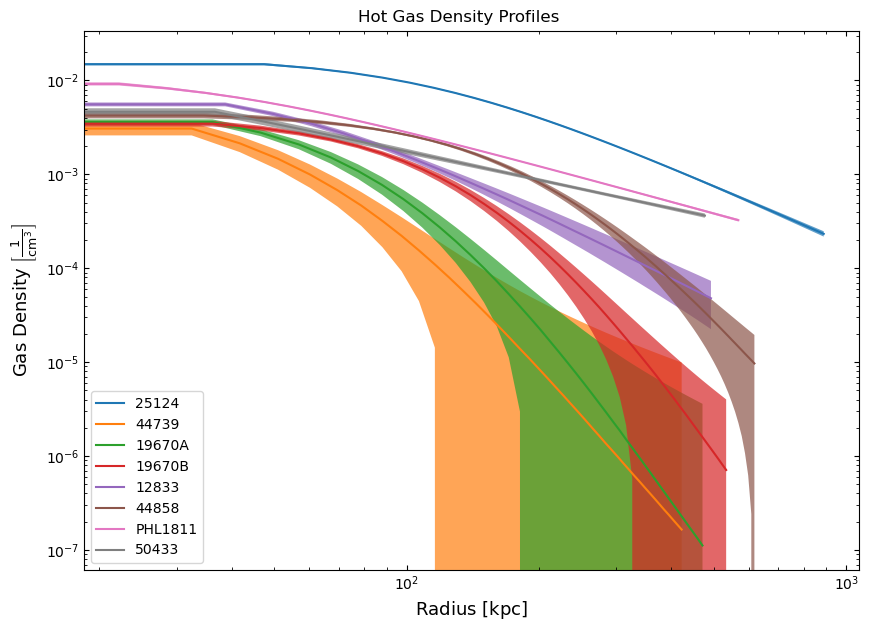

In [31]:
BaseAggregateProfile1D(d_profs).view(joined_points=True, custom_title='Hot Gas Density Profiles', 
                                     save_path='../../outputs/figures/hot_gas_dens_profs.pdf')

## Measuring hot gas mass

Now that we have generated 3D density profiles, it is trivial to calculate the gas mass enclosed within some radii. This is done for the $R_{500}$ and $R_{2500}$ results of the three different ways that we ran the XGA-LTR:

In [26]:
gm500 = []
gm2500 = []
metfree_gm500 = []
metfree_gm2500 = []
froztemp_gm500 = []
froztemp_gm2500 = []

for dp in d_profs:
    rel_src = srcs[dp.src_name]
    dp.fit('king', progress_bar=False)
    if dp is not None:
        gm500.append(dp.gas_mass('king', rel_src.r500)[0])
        
        rel_rad = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        gm2500.append(dp.gas_mass('king', rel_rad)[0])
        
        rel_rad = Quantity(r500_metfree_samp[r500_metfree_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        metfree_gm500.append(dp.gas_mass('king', rel_rad)[0])
        rel_rad = Quantity(r2500_metfree_samp[r2500_metfree_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        metfree_gm2500.append(dp.gas_mass('king', rel_rad)[0])
        
        rel_rad = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        froztemp_gm500.append(dp.gas_mass('king', rel_rad)[0])
        rel_rad = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == rel_src.name].iloc[0]['r2500'], 
                           'kpc')
        froztemp_gm2500.append(dp.gas_mass('king', rel_rad)[0])
        
    else:
        null_res = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        gm500.append(null_res)
        gm2500.append(null_res)
        metfree_gm500.append(null_res)
        metfree_gm2500.append(null_res)
        froztemp_gm500.append(null_res)
        froztemp_gm2500.append(null_res)
    
gm500 = Quantity(gm500)
gm500[gm500 == 0] = np.NaN
gm2500 = Quantity(gm2500)
gm2500[gm2500 == 0] = np.NaN

metfree_gm500 = Quantity(metfree_gm500)
metfree_gm500[metfree_gm500 == 0] = np.NaN
metfree_gm2500 = Quantity(metfree_gm2500)
metfree_gm2500[metfree_gm2500 == 0] = np.NaN

froztemp_gm500 = Quantity(froztemp_gm500)
froztemp_gm500[froztemp_gm500 == 0] = np.NaN
froztemp_gm2500 = Quantity(froztemp_gm2500)
froztemp_gm2500[froztemp_gm2500 == 0] = np.NaN

/tmp/local/26851671/ipykernel_17361/2910814318.py:12: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500)[0])
/tmp/local/26851671/ipykernel_17361/2910814318.py:23: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  froztemp_gm500.append(dp.gas_mass('king', rel_rad)[0])
/tmp/local/26851671/ipykernel_17361/2910814318.py:18: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  metfree_gm500.append(dp.gas_mass('king', rel_rad)[0])


## Saving gas masses

Now that we have measured the gas masses, we wish to save them to a csv:

In [85]:
gm_data = (np.hstack([gm500, gm2500, metfree_gm500, metfree_gm2500, froztemp_gm500, 
                     froztemp_gm2500]).value / 1e+13).round(4)
gm_data = np.hstack([srcs.names[..., None], gm_data])

gm_cols = ['name', 'gm500', 'gm500-', 'gm500+', 'gm2500', 'gm2500-', 'gm2500+', 
           'gm_metfree500', 'gm_metfree500-', 'gm_metfree500+', 'gm_metfree2500', 'gm_metfree2500-', 
           'gm_metfree2500+', 
           'gm_froztemp500', 'gm_froztemp500-', 'gm_froztemp500+', 'gm_froztemp2500', 'gm_froztemp2500-', 
           'gm_froztemp2500+']

gm_pd = pd.DataFrame(gm_data, columns=gm_cols)
gm_pd.to_csv("../../outputs/results/all_hot_gm_measurements.csv", index=False)
gm_pd

,name,gm500,gm500-,gm500+,gm2500,gm2500-,gm2500+,gm_metfree500,gm_metfree500-,gm_metfree500+,gm_metfree2500,gm_metfree2500-,gm_metfree2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,25124,2.7333,0.0125,0.0123,0.8693,0.0028,0.0028,2.6411,0.0117,0.0115,0.8866,0.0028,0.0028,2.6406,0.0116,0.0115,0.9933,0.0031,0.0031
1,44739,0.0063,0.0009,0.0012,0.0062,0.0008,0.0009,0.0063,0.0009,0.0012,0.0062,0.0008,0.0009,0.0063,0.0009,0.0012,0.0062,0.0008,0.0009
2,19670A,0.0141,0.0012,0.0013,nan,nan,nan,0.0141,0.0012,0.0013,nan,nan,nan,0.0141,0.0012,0.0013,nan,nan,nan
3,19670B,0.0441,0.0019,0.002,0.0402,0.0013,0.0013,0.0439,0.0019,0.0019,0.036,0.001,0.001,0.044,0.0019,0.0019,0.035,0.001,0.001
4,12833,0.1195,0.0055,0.0055,0.053,0.0012,0.0012,0.1172,0.0053,0.0053,0.0545,0.0013,0.0013,0.1335,0.0069,0.007,0.0628,0.0016,0.0016
5,44858,0.1927,0.0049,0.0047,0.1303,0.0016,0.0016,0.1929,0.0049,0.0048,0.1274,0.0015,0.0016,0.2,0.0059,0.0058,0.1486,0.002,0.0021
6,PHL1811,0.6444,0.0017,0.0017,0.1577,0.0004,0.0004,0.6214,0.0016,0.0016,0.1643,0.0004,0.0004,0.8061,0.0024,0.0025,0.2232,0.0005,0.0005
7,50433,0.373,0.0028,0.0029,0.0653,0.0008,0.0008,0.3658,0.0028,0.0028,0.0623,0.0008,0.0008,0.4111,0.0032,0.0032,0.1112,0.0011,0.0011


## Comparing hot gas masses

As discussed in the XGA-LTR notebook elsewhere in this repository, we have run the pipeline which measures overdensity radii in three different modes, which results in slightly different values - as we measure the hot gas mass within a particular radius we compare the results from all the different versions of $R_{500}$ and $R_{2500}$:

In [32]:
stand_col = 'tab:cyan'
metfree_col = 'firebrick'
froztemp_col = 'goldenrod'

### $R_{500}$

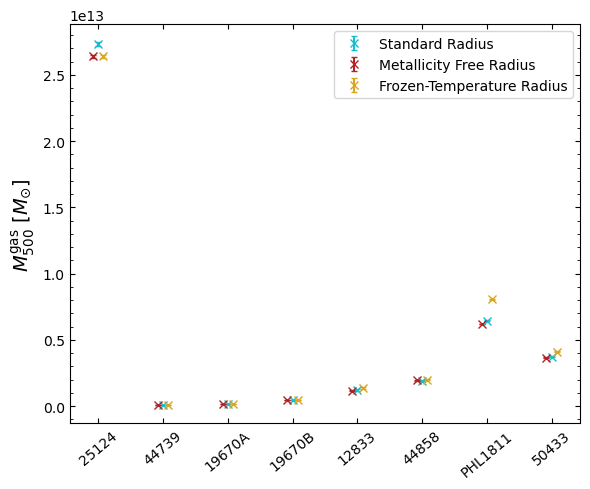

In [50]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm500[:, 0].value, yerr=gm500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) - x_offset, metfree_gm500[:, 0].value, 
             yerr=metfree_gm500[:, 1:].T.value, fmt='x', 
             label="Metallicity Free Radius", color=metfree_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm500[:, 0].value, 
             yerr=froztemp_gm500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm500_comp.pdf')
plt.show()

### $R_{2500}$

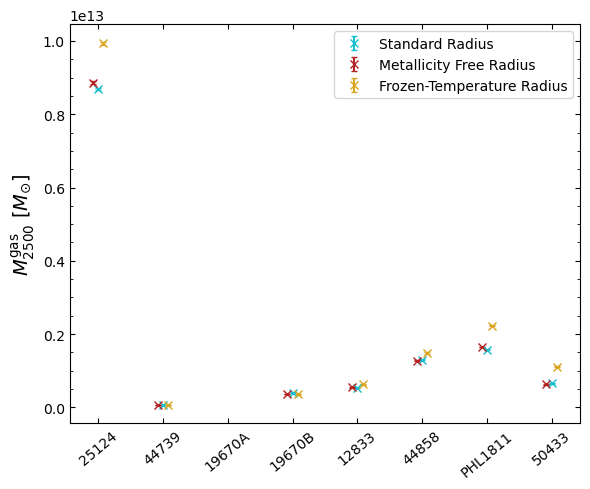

In [52]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm2500[:, 0].value, yerr=gm2500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) - x_offset, metfree_gm2500[:, 0].value, 
             yerr=metfree_gm2500[:, 1:].T.value, fmt='x', 
             label="Metallicity Free Radius", color=metfree_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm2500[:, 0].value, 
             yerr=froztemp_gm2500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{2500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm2500_comp.pdf')
plt.show()